### Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [3]:
import warnings
warnings.filterwarnings("ignore")


In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

D:\python\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

#filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [6]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [8]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [9]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [11]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [15]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

In [18]:
pos_reviews=final[final['Score']== 1].sample(n=50000)
neg_reviews=final[final['Score']== 0].sample(n=50000)
a=(pos_reviews,neg_reviews)
final=pd.concat(a)

# FEATURE ENGINEERING

In [19]:
#Concating both the summary and text inorder to improve the model and then using it to test the model

#https://stackoverflow.com/questions/19377969/combine-two-columns-of-text-in-dataframe-in-pandas-python

final['TEXT_SUMMARY']=final['Text'] +" "+ final["Summary"]

final=final.sort_values(by='Time')



final['TEXT_SUMMARY'][:1]==(final['Text'][:1]+" "+final['Summary'][:1])


417838    True
dtype: bool

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [20]:
# printing some random reviews
sent_0 =final['TEXT_SUMMARY'].values[0]


sent_1000 =final['TEXT_SUMMARY'].values[1000]


sent_1500 =final['TEXT_SUMMARY'].values[1500]


sent_4900 =final['TEXT_SUMMARY'].values[4900]


# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()


soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()


soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()


soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()

# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

sent_1500 = decontracted(sent_1500)


#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()


#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)


# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

Beetlejuice is an excellent and funny movie. Keaton is hilarious as the wacky beetlejuice. The great special effects help the film. I think this is one of the best movies ever made and I'm sure you'll agree. For a good  time, watch beetlejuice! FANTASTIC!


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:10<00:00, 1422.34it/s]


In [21]:
preprocessed_reviews[1500]

'bought bags husband along brands looking buy bigger quanties tubi licorice simply best wonderful taste licorice not powered anise wonderful molasses true licorice'

In [22]:
import pickle
with open("final['Score'].pkl",'rb') as f :
    final_Score =pickle.load(f)
with open('preprocessed_reviews.pkl','rb') as f :
    preprocessed_reviews=pickle.load(f)

# [4] Featurization

In [23]:
len(preprocessed_reviews)

100000

In [24]:
len(final_Score)

100000

In [25]:
# SPLITTING THE DATA INTO TEST TRAIN AND CV
x= preprocessed_reviews



## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
final_bigram_counts = count_vect.fit_transform(x)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (100000, 500)
the number of unique words including both unigrams and bigrams  500


## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [27]:
print("VECTOR OF TEXT AND SUMMARY")
print("                          ")
#tfidf_train
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=2000)
train_tf_idf = tf_idf_vect.fit_transform(x)
print("the type of count vectorizer ",type(train_tf_idf))
print("the shape of out text TFIDF vectorizer ",train_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", train_tf_idf.get_shape()[1])


VECTOR OF TEXT AND SUMMARY
                                  
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (100000, 2000)
the number of unique words including both unigrams and bigrams  2000


In [28]:
top_2000=tf_idf_vect.get_feature_names()

In [29]:
len(top_2000)

2000

### [5.2] Calulation of Co-occurrence matrix

In [30]:
from tqdm import tqdm
n_neighbor = 5
occ_matrix = np.zeros((2000,2000))
for row in tqdm(final['TEXT_SUMMARY'].values):
    words_in_row = row.split()
    
    for index,word in enumerate(words_in_row):
        if word in top_2000:
            for j in range(max(index-n_neighbor,0),min((index+n_neighbor),len(words_in_row)-1) + 1):
                if words_in_row[j] in top_2000:
                     occ_matrix[top_2000.index(word),top_2000.index
                     (words_in_row[j])] += 1
                else:
                     pass
            else:
                pass

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [34:57<00:00, 47.68it/s]


In [77]:
occ_matrix.shape

(2000, 2000)



### [5.3] Finding optimal value for number of components (n) to be retained.

In [31]:
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
N=[10]
for i in N:
    percentage_var_explained =[]
    svd = TruncatedSVD(n_components=i,random_state=0)
    svd.fit(occ_matrix)
    percentage_var_explained = svd.explained_variance_ 
print("The list of  variance ratio is" ,percentage_var_explained )


The list of  variance ratio is [2533207.18647535 1182213.00893413  394603.27390674  331416.56765056
  305218.28751061  285580.18121172  267242.81979007  192146.87152897
  168591.96214487  165555.06662509]


Text(0.5,0,'k-cluster')

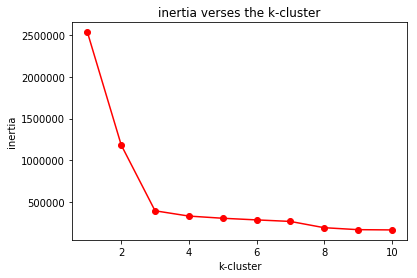

In [32]:
y=range(1,11)
plt.plot(y,percentage_var_explained ,'r',marker="o")
plt.title('inertia verses the k-cluster')
plt.ylabel('inertia')
plt.xlabel('k-cluster')
    

Considering n_components=3

In [33]:
svd = TruncatedSVD(n_components=3,random_state=0)
data=svd.fit_transform(occ_matrix)

### [5.4] Applying k-means clustering

In [34]:
from sklearn.cluster import KMeans 
def kMeans(x_train):
    clus=range(1,19,2)
    list_inertia=[]
    for i in  clus:
        a=[]
        clf=KMeans(n_clusters=i,   n_jobs=-1, algorithm="auto",precompute_distances="auto")
        clf.fit(x_train)
        a=clf.inertia_
        list_inertia.append(a)
        print("For no of cluster ",i, " the inertia is ",a)
    print(list_inertia)
    return list_inertia,clf

In [35]:
def inertia_curve(list):
    y=range(1,19,2)
    plt.plot(y,list,'r',marker="o")
    plt.title('inertia verses the k-cluster')
    plt.ylabel('inertia')
    plt.xlabel('k-cluster')
    
#     plt.show()


In [36]:
def wordcloud_of_cluster(vect,k,X):
    clf=KMeans(n_clusters=k).fit(X)
    values=clf.cluster_centers_.argsort()[:,::-1]
    feature_names=vect.get_feature_names()
    return k,values,feature_names,clf

In [37]:

# Please write all the code with proper documentation
list_kmeans_bow,clf=kMeans(x_train=data)


For no of cluster  1  the inertia is  8220058531.073081
For no of cluster  3  the inertia is  1184137462.788732
For no of cluster  5  the inertia is  225583586.3469627
For no of cluster  7  the inertia is  106961931.42084475
For no of cluster  9  the inertia is  71958844.62020656
For no of cluster  11  the inertia is  56802992.53235139
For no of cluster  13  the inertia is  43670043.15551762
For no of cluster  15  the inertia is  33365319.733824607
For no of cluster  17  the inertia is  26697138.303846255
[8220058531.073081, 1184137462.788732, 225583586.3469627, 106961931.42084475, 71958844.62020656, 56802992.53235139, 43670043.15551762, 33365319.733824607, 26697138.303846255]


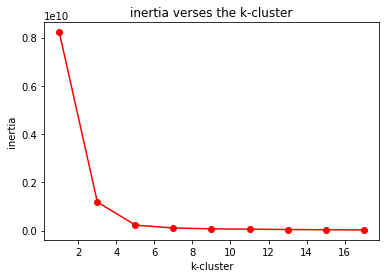

In [38]:
inertia_curve(list=list_kmeans_bow)

cosidering number of cluster k=4

In [39]:
k,values,feature_names,clf=wordcloud_of_cluster(vect=count_vect,k=4,X=data)

In [56]:
# Getting all the reviews in different clusters
#below function taken from https://github.com/PushpendraSinghChauhan/Amazon-Fine-FoodReviews/blob/master/Apply%20clustering%20%20on%20Amazon%20Food%20Reviews.ipynb

cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []

lables=list(set(clf.labels_))
for i in lables:
    
    for i in range(clf.labels_.shape[0]):
        if clf.labels_[i] == 0:
            cluster1.append(top_2000[i])
        elif clf.labels_[i] == 1:
            cluster2.append(top_2000[i])
        elif clf.labels_[i] == 2:
            cluster3.append(top_2000[i])

        else:
            cluster4.append(top_2000[i])
   
   
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))


No. of reviews in Cluster-1 :  7972

No. of reviews in Cluster-2 :  4

No. of reviews in Cluster-3 :  4

No. of reviews in Cluster-4 :  20


In [57]:
clf.labels_.shape[0]

2000

****CLUSTER 1****

<function show at 0x00000203607ED8C8>
******************************


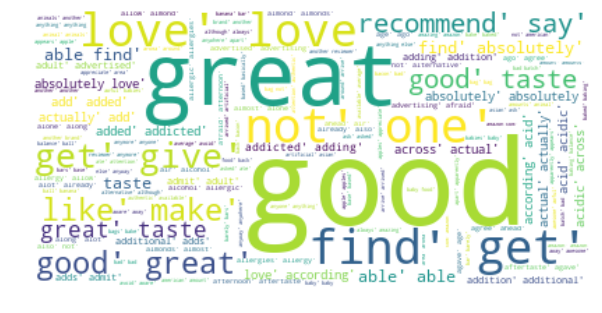

In [58]:
from wordcloud import WordCloud
wordcloud=WordCloud(background_color="white").generate(str(cluster1))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
        


****CLUSTER 2****

<function show at 0x00000203607ED8C8>
******************************


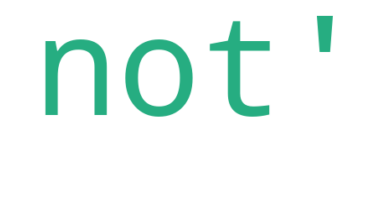

In [59]:
from wordcloud import WordCloud
wordcloud=WordCloud(background_color="white").generate(str(cluster2))
plt.figure(figsize=(6,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
        


****CLUSTER 3****

<function show at 0x00000203607ED8C8>
******************************


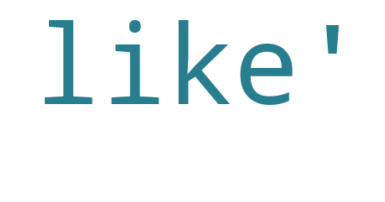

In [60]:
from wordcloud import WordCloud
wordcloud=WordCloud(background_color="white").generate(str(cluster3))
plt.figure(figsize=(6,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
        


****CLUSTER 4****

<function show at 0x00000203607ED8C8>
******************************


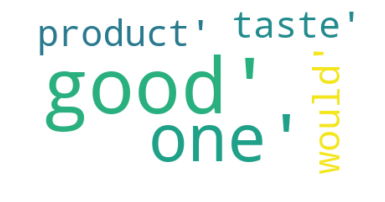

In [61]:
from wordcloud import WordCloud
wordcloud=WordCloud(background_color="white").generate(str(cluster4))
plt.figure(figsize=(6,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
print(plt.show)
print("******************************")
        


****SIMILAR WORDS****

In [75]:
from sklearn.metrics.pairwise import cosine_similarity
for j in range(1,5):
    similar_words=cosine_similarity(occ_matrix)
    word_vector=similar_words[top_2000.index(top_2000[j])]
    print("similar words to",top_2000[j])
    index =word_vector.argsort()[::-1][1:11]
    for i in range(len(index)):
        print(top_2000[index[i]])
    print("*"*50)

similar words to able find
fructose
freeze
freeze dried
freezer
french
french roast
fresh
freshness
fridge
friend
**************************************************
similar words to absolutely
love
no
loves
loved
dr
not
taste
delicious
longer
disgusting
**************************************************
similar words to absolutely love
fructose
freeze
freeze dried
freezer
french
french roast
fresh
freshness
fridge
friend
**************************************************
similar words to according
directions
package
prepared
made
instructions
taste
not
followed
product
good
**************************************************


****CONCLUSION****

1) Here we take maximum 2000 top features from tfidf

2) Then constructed co-occurance matrix of 2000 top features

3) Used co-oocurance in truncated-svd

4) Using the data in the model in k-means

5) Forming the wordcloud from the clusters

6) Similar words 